In [1]:
import pandas as pd
import numpy as np

In [2]:
# from numba import vectorize
class Features():
    def __init__(self, nsn, nal):
        self.D = {}
        self.nsn = nsn
        self.nal = nal
        self.nt = nal - nsn
        
#     @vectorize
    def dicinc(self, x, cl):
#         x, cl = w
        try:
            y = self.D[x]
            y[0] += 1
            if cl == 1.0:
                y[1] += 1 #if cl == 1.0 else -1
        except KeyError:
            self.D[x] = [1, 1] #if cl == 1.0 else [1, -1]
#     @vectorize
    def spliter(self, x, cl, ps=2):
        l = len(x)
        for i in range(0, l - ps + 1):
             self.dicinc(x[i:i+ps], cl)
    def dicsort(self):
        for key in self.D:
            y = self.D[key]
            a1 = y[1]
            a0 = y[0] - y[1]
            b1 = self.nsn - y[1]
            b0 = self.nt - a0
            y[1] = (a1*b0 - a0*b1) / self.nal / self.nal
    def tolist(self):
        l = list(map(lambda x: (self.D[x])[1], self.D))
#         print(l)
        l.sort()
        return l, l[0:5], l[-5:-1]
    def get_feature(self, x, ps=2):
        wl = []
#         x.lower()
        l = len(x)
        for i in range(0, l - ps + 1):
            fr = x[i:i+ps]
            try:
                y = self.D[fr]
                wl.append(y[1])
            except KeyError:
                continue
#         wl.sort()
        if len(wl) == 0:
            return 0.0
#         ma = np.mean(np.array(wl))
        ma = max(wl)
        return ma if ma >= 0.0 else min(wl)
            
# spliter('ва')

In [5]:
# file = open('linear_train.txt', 'r')
# lo = list(map(lambda x: [x[0], float(x[1])], map(lambda x: x.split(', '), map(str.rstrip, file.readlines()))))
# file.close()
raw = pd.read_csv('linear_train.txt', header=None)
f = np.vectorize(lambda x: x[-5:])
slow = np.vectorize(str.lower)
suffs = slow(f(raw[0].values))
# suffs = f(raw[0].values)
clses = raw[1].values

F = Features(np.sum(clses), clses.size)
# F.spliter(suffs, clses)
list(map(lambda x, y: F.spliter(x, y), suffs, clses))
# F.D
F.dicsort()
l, mi, ma = F.tolist()
print(mi, ma)
# F.D['ин']
# print(F.nsn, F.nal)
gf = np.array(list(map(F.get_feature, suffs)))
ma = np.amax(gf)
mi = np.amin(gf)
# print(ma)
feres = pd.DataFrame({'5_2': gf})


[-0.0091827110183224179, -0.0059274448581890619, -0.0054804202910119244, -0.0047556112056476429, -0.0044134493168002664] [0.0034716230579157049, 0.0042655668054941368, 0.0048349382303353701, 0.0055311911193519255]


In [6]:
for key in F.D:
    y = F.D[key]
    if y[1] >= 0.001:
        print(key, y)

он [3467, 0.0048349382303353701]
ар [2523, 0.0011077017216400279]
ро [3933, 0.0011381413083400738]
на [3519, 0.0024933581356264604]
но [4734, 0.0013350954346953929]
ов [6557, 0.0064408256783926926]
ко [4737, 0.0022096348310082455]
ом [6342, 0.0026201620003851608]
ин [4046, 0.0042655668054941368]
вы [533, 0.0019533638272772255]
ым [494, 0.0017964848402464272]
ев [1305, 0.0027917090275204701]
са [1564, 0.0011037764358613306]
со [1601, 0.0034716230579157049]
ва [4317, 0.001105769710099346]
ву [629, 0.0012623859482282457]
лл [723, 0.0021907064078948587]
бе [718, 0.0010914293768043829]
ер [4710, 0.0055311911193519255]
рд [620, 0.0012716961278602141]
ай [660, 0.0012500398615950654]
ну [1215, 0.0016916110762857203]
нс [750, 0.0022909708831990168]
ск [1281, 0.0023727842009747314]
йн [375, 0.0011504160190687416]
нг [783, 0.0012707180640351599]
нд [876, 0.0010463178603047569]
тт [252, 0.0010508485771209158]


In [47]:
# fff = pd.read_csv('linear_test.txt', header=None)
# fff
# # file = open('linear_test.txt', 'r')
# # lo = list(map(lambda x: [x[0], float(x[1])], map(lambda x: x.split(', '), map(str.rstrip, file.readlines()))))
# # file.close()
# # raw = pd.DataFrame(lo)
# f = np.vectorize(lambda x: x[-5:])
# slow = np.vectorize(str.lower)
# # suffs = slow(f(raw[0].values))
# # f = np.vectorize(lambda x: x[-5:])
# suffs = slow(f(fff[0].values))
# # clses = fff[1].values


[-2.10909681 -2.11162849 -2.06608198 ..., -2.07156372 -2.10981941
 -2.09135764]
0.703203509866


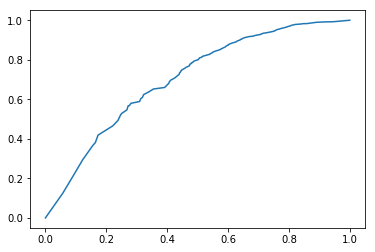

In [7]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
X = gf.reshape((gf.size, 1))
Y = clses
# X_test = np.array(list(map(F.get_feature, suffs)))
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.7, random_state=42)

clf = linear_model.SGDClassifier(loss='log', penalty='none')
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test.reshape((X_test.size, 1)))
print(y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr)
plt.show()
# y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
# accuracy_score(y_test, y_pred)
# res = pd.DataFrame(y_pred)
# res.to_csv('res1.txt')
# print(y_test.size, y_pred.size)
# print(y_pred)

In [13]:
# file = open('linear_train.txt', 'r')
# lo = list(map(lambda x: [x[0], float(x[1])], map(lambda x: x.split(', '), map(str.rstrip, file.readlines()))))
# file.close()
raw = pd.read_csv('linear_train.txt', header=None)
clses = raw[1].values
slow = np.vectorize(str.lower)

fff_test = pd.read_csv('linear_test.txt', header=None)

for j in [2, 3, 4]:
    for i in range(5, j - 1, -1):
        f = np.vectorize(lambda x: x[-i:])
        suffs = slow(f(raw[0].values))
        suffs_t = slow(f(fff_test[0].values))
        F = Features(np.sum(clses), clses.size)
        list(map(lambda x, y: F.spliter(x, y, ps=j), suffs, clses))
        F.dicsort()
        # l, mi, ma = F.tolist()
        # print(mi, ma)
        gf = np.array(list(map(lambda x: F.get_feature(x, ps=j), suffs)))
        gf_t = np.array(list(map(lambda x: F.get_feature(x, ps=j), suffs_t)))
        raw['r'+str(i)+'_'+str(j)] = pd.DataFrame(gf)
        fff_test['r'+str(i)+'_'+str(j)] = pd.DataFrame(gf_t)

tit = np.array(list(map(lambda x: 1.0 if x.istitle() else 0.0, raw[0].values)))
raw['tit'] = pd.DataFrame(tit)
tit = np.array(list(map(lambda x: 1.0 if x.istitle() else 0.0, fff_test[0].values)))
fff_test['tit'] = pd.DataFrame(tit)

caps = np.array(list(map(lambda x: 1.0 if x.isupper() else 0.0, raw[0].values)))
raw['caps'] = pd.DataFrame(caps)
caps = np.array(list(map(lambda x: 1.0 if x.isupper() else 0.0, fff_test[0].values)))
fff_test['caps'] = pd.DataFrame(caps)

raw.head()
fff_test.head()

,0,r5_2,r4_2,r3_2,r2_2,r5_3,r4_3,r3_3,r5_4,r4_4,tit,caps
0,Аалто,0.000403,0.000589,0.000081,0.000051,0.000326,0.000142,0.000009,0.000007,0.000009,1.0,0.0
1,ААР,0.001108,0.000534,0.000136,0.000025,0.000006,0.000009,0.000009,0.000000,0.000000,0.0,1.0
2,Аара,0.001108,0.000534,0.000622,0.001097,0.000006,0.000010,0.000062,0.000000,0.000000,1.0,0.0
3,Ааре,0.001108,0.000688,0.000179,-0.000037,0.000072,0.000009,-0.000032,0.000000,0.000000,1.0,0.0
4,Аарон,0.004835,0.004647,0.003885,0.001556,0.000273,0.000143,0.000040,0.000061,0.000016,1.0,0.0


0.938268060422


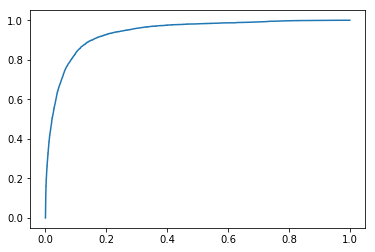

In [14]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
X = raw.drop([0, 1], axis=1).values
Y = clses
# X_test = np.array(list(map(F.get_feature, suffs)))
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.7, random_state=42)

# clf = linear_model.SGDClassifier(loss='log', penalty='l1')
# clf = linear_model.LogisticRegressionCV(penalty='l2', cv=20)
clf = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=7)
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
# print(y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr)
plt.show()

In [ ]:
# fff = pd.read_csv('linear_test.txt', header=None)
# # fff
# # file = open('linear_test.txt', 'r')
# # lo = list(map(lambda x: [x[0], float(x[1])], map(lambda x: x.split(', '), map(str.rstrip, file.readlines()))))
# # file.close()
# # raw = pd.DataFrame(lo)
# f = np.vectorize(lambda x: x[-5:])
# slow = np.vectorize(str.lower)
# # suffs = slow(f(raw[0].values))
# # f = np.vectorize(lambda x: x[-5:])
# suffs = slow(f(fff[0].values))
# # clses = fff[1].values

In [17]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, auc
X = raw.drop([0, 1], axis=1).values
X_t = fff_test.drop([0], axis=1).values
Y = clses

# clf = linear_model.SGDClassifier(loss='log', penalty='l1')
# clf = linear_model.LogisticRegressionCV()
clf = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=7)
clf.fit(X, Y)
y_pred = clf.predict(X_t)
res = pd.DataFrame(y_pred)
res.to_csv('min_4.txt')
print(y_test.size, y_pred.size)

70986 188920
